# Aiffel DS Main Quest#1 (Node#15)

### 데이터에 근거하여 고객들을 분류하고 이를 시각화해서 각 타겟별 타겟팅 전략을 세우기

1. 데이터 전처리
2. RFM +추가 Feature

- 전처리와 RFM 은 SQL
- 이후 파이썬과 머신러닝 이용한 세그멘테이션
> 분석 하다보면 멀티링구얼이 된다!

# 데이터 전처리
1. 결측치 제거
2. 중복값 처리
3. 오류값 처리
 - column 별 살펴보고 컬럼/오류 특성 파악하여 어떤 방식으로 필터&제거할지 판단
 - e.g. 이런 오류값들이 전체의 몇 % 인가?

## 결측치 제거

In [ ]:
# 전체 데이터는 몇 행으로 구성되어 있는지 확인해 봅시다. 
SELECT COUNT(InvoiceNo)
, COUNT(StockCode)
, COUNT(Description)
, COUNT(Quantity)
, COUNT(InvoiceDate)
, COUNT(UnitPrice)
, COUNT(CustomerID)
, COUNT(Country)
FROM aiffel-ds-2024.quest_node15_0115.data AS data

# 컬럼별 누락값 비율 계산 - CASE WHEN 사용
SELECT
    'Description' AS column_name,
    ROUND(SUM(CASE WHEN Description IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM aiffel-ds-2024.quest_node15_0115.data
UNION ALL
SELECT 
    'CustomerID' AS column_name,
    ROUND(SUM(CASE WHEN CustomerID IS NULL THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS missing_percentage
FROM aiffel-ds-2024.quest_node15_0115.data

# 결측치 처리를 위해 StockCode로 Description 매칭해서 채워 넣어줄 수 있는지 확인
SELECT DISTINCT Description
FROM aiffel-ds-2024.quest_node15_0115.data
WHERE StockCode = '85123A'; # 결과값이 다 달라서 매칭 없이 제거해주기로 함

# 결측치 제거
DELETE FROM aiffel-ds-2024.quest_node15_0115.data
WHERE CustomerID IS NULL # 27%나 NULL 이면 분석이 어려움
    OR Description IS NULL

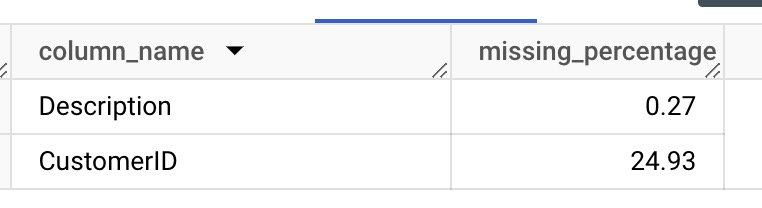

#### Note

DELETE *
FROM aiffel-ds-2024.quest_node15_0115.data
WHERE CustomerID IS NULL 
    OR Description IS NULL
    
라고 했더니 안됐다. DELETE 는 'DELETE FROM' 이 전체 문구라고 한다

## 중복값 확인

In [ ]:
# 우선 중복된 행들이 있는지를 확인한 다음, 이를 해결하기 위한 가장 효과적인 전략을 선택하겠습니다.

WITH duplicates AS (
  SELECT InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, COUNT(*)
FROM aiffel-ds-2024.quest_node15_0115.data
GROUP BY InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country
HAVING COUNT(*) > 1
)
SELECT COUNT(*)
FROM duplicates # 4837

# 중복값 제거
CREATE OR REPLACE TABLE aiffel-ds-2024.quest_node15_0115.data AS
SELECT DISTINCT *
FROM aiffel-ds-2024.quest_node15_0115.data

SELECT COUNT(*)
FROM  aiffel-ds-2024.quest_node15_0115.data # 401604

#### Note

중복 행 찾는 걸 컬럼별로 SELECT col FROM GROUP BY 1 HAVING CNT > 1 이런 방식으로 하나하나 해서 전부 UNION ALL 해줬었는데, (컬럼별로 중복 항 개수 찾는 방식) 그냥 모든 컬럼의 값이 같은 행들의 총계를 찾는 거였다. 
그런데 위와 같이 코드 쓰는 것도 중복이 너무 심한 것 같아 어떻게 더 깔끔하게 쓰냐고 GPT에게 물어보니 Window function 을 알려줬다.
복습의 중요성!!

하지만 WINDOW FUNCTION 에서는 FLOAT 64 기준으로 파티션 할 수 없다고 떠서
그냥 반복적이더라도 두 번 써주기로 했다

GPT 가 준 코드가 잘 이해가 안되서 한 번 쿼리 돌려보려고 했었는데... CAST 써서 STRING 으로 바꿔주는게 더 노가다였다.
Window f 실습은 다음 기회에


## 오류값 처리

In [ ]:
# 컬럼 단위로 데이터를 살펴보면서 클렌징이 필요한 값들이 있는지 살펴보기

### InvoiceNo

SELECT DISTINCT InvoiceNo
FROM aiffel-ds-2024.quest_node15_0115.data
LIMIT 100

#앞자리가 C로 시작하는 것들이 있음

SELECT * 
FROM aiffel-ds-2024.quest_node15_0115.data
WHERE InvoiceNo Like 'C%'
LIMIT 100

# 구매 건 상태가 Canceled 인 데이터의 비율(%)
SELECT ROUND(SUM(CASE WHEN InvoiceNo Like 'C%' THEN 1 ELSE 0 END)/ COUNT(InvoiceNo), 3) 
FROM aiffel-ds-2024.quest_node15_0115.data



In [ ]:
### StockCode
SELECT StockCode, COUNT(*) AS sell_cnt 
FROM aiffel-ds-2024.quest_node15_0115.data
GROUP BY 1
ORDER BY sell_cnt DESC
LIMIT 10

WITH UniqueStockCodes AS (
  SELECT DISTINCT StockCode
  FROM project_name.modulabs_project.data
)
SELECT
  LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count,
  COUNT(*) AS stock_cnt
FROM UniqueStockCodes
GROUP BY number_count
ORDER BY stock_cnt DESC;

SELECT DISTINCT StockCode, number_count
FROM (
  SELECT StockCode,
    LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count
  FROM aiffel-ds-2024.quest_node15_0115.data
) 
WHERE number_count < 5

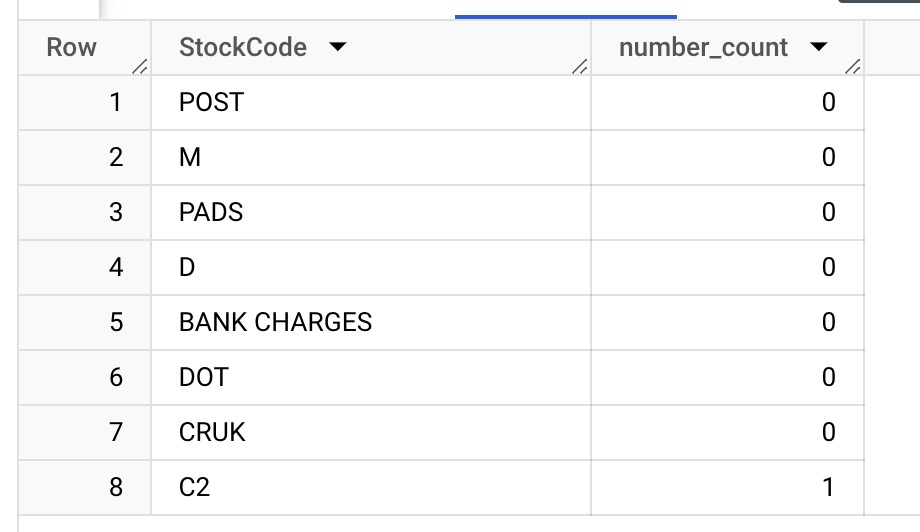

In [ ]:
# 해당 코드 값들을 가지고 있는 데이터 수는 전체 데이터 수 대비 몇 퍼센트일까요? 소수점 두번째 자리까지 구해 주세요.

WITH temp_d AS (
    SELECT StockCode,
    LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) AS number_count
  FROM aiffel-ds-2024.quest_node15_0115.data
)
SELECT ROUND(SUM(CASE WHEN number_count < 5 THEN 1 ELSE 0 END)/ COUNT(StockCode), 5) 
FROM temp_d # 0.00477

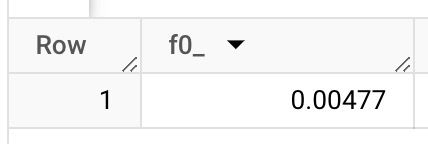

In [ ]:
# 제품과 관련되지 않은 거래 기록을 제거하는 쿼리문을 작성해 주세요.

DELETE FROM aiffel-ds-2024.quest_node15_0115.data 
WHERE StockCode IN (
  SELECT DISTINCT StockCode
  FROM aiffel-ds-2024.quest_node15_0115.data
  WHERE LENGTH(StockCode) - LENGTH(REGEXP_REPLACE(StockCode, r'[0-9]', '')) < 5
);


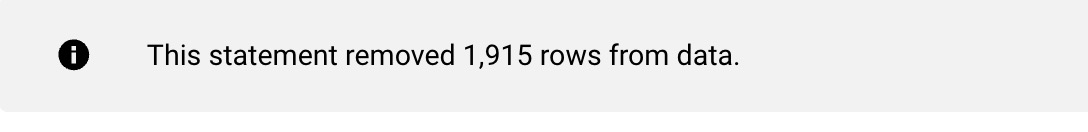

In [ ]:
# Description

SELECT Description, COUNT(*) AS description_cnt
FROM aiffel-ds-2024.quest_node15_0115.data
GROUP BY 1
ORDER BY 2 DESC # 대소문자와 제품이 아닌 서비스에 대한 설명 포함됨

# 소문자 포함한 아이들 뽑아보기
SELECT DISTINCT Description
FROM aiffel-ds-2024.quest_node15_0115.data
WHERE REGEXP_CONTAINS(Description, r'[a-z]');

# 서비스 관련 정보를 포함하는 행들을 제거
DELETE FROM aiffel-ds-2024.quest_node15_0115.data
WHERE Description LIKE '%Carriage%' OR Description LIKE '%Image%';


# 대소문자를 혼합하고 있는 데이터를 대문자로 표준화
CREATE OR REPLACE TABLE aiffel-ds-2024.quest_node15_0115.data AS
SELECT
 * EXCEPT (Description),
   UPPER(Description) AS Description 
FROM aiffel-ds-2024.quest_node15_0115.data # 이렇게 하고 다시  REGEXP_CONTAINS(Description, r'[a-z]') 를 뽑아보면 결과가 안나온다. 삭제 완료!

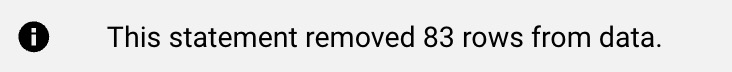

In [ ]:
# UnitPrice

# 이번에는 UnitPrice에서 이상치를 찾아봅시다. 최솟값, 최댓값, 평균 데이터를 확인해 봄으로써, 단위 가격의 요약 통계량을 살펴보겠습니다.
SELECT MIN(UnitPrice) AS min_price
, MAX(UnitPrice)AS max_price
, AVG(UnitPrice) AS avg_price
FROM aiffel-ds-2024.quest_node15_0115.data


# 단가가 0원인 거래의 개수, 구매 수량(Quantity)의 최솟값, 최댓값, 평균을 구해 보세요.
SELECT COUNT(Quantity) AS cnt_quantity
, MIN(Quantity) AS min_quantity
, MAX(Quantity) AS max_quantity
, AVG(Quantity) AS avg_quantity
FROM aiffel-ds-2024.quest_node15_0115.data
WHERE UnitPrice = 0



# 이 데이터(UnitPrice = 0)를 제거하고 일관된 데이터셋을 유지하도록 하겠습니다.
CREATE OR REPLACE TABLE aiffel-ds-2024.quest_node15_0115.data AS 
SELECT *
FROM aiffel-ds-2024.quest_node15_0115.data
WHERE UnitPrice != 0

# UnitPrice 편차가 엄청 크다

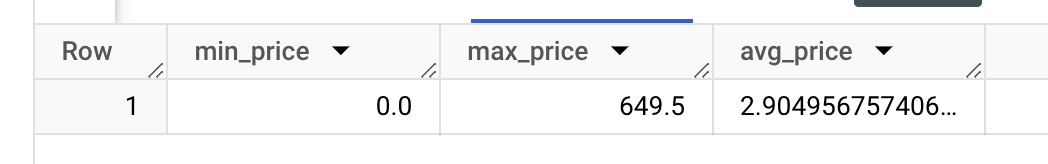

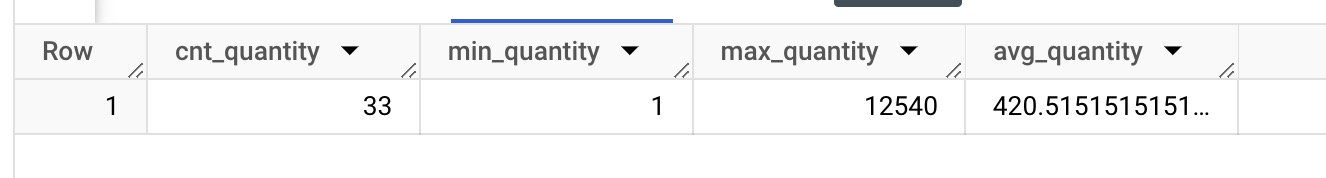

# RFM 스코어

- Recency는 고객이 마지막으로 구매한 시점을 나타냅니다. 최근에 구매한 고객들은 더 자주 구매할 가능성이 높기 때문에, 최신성 점수가 높은지를 고려합니다.
- Frequency는 특정 기간 동안 고객이 얼마나 자주 우리의 제품이나 서비스를 구매하는지를 나타냅니다. 빈번하게 구매하는 고객은 충성도가 높은 고객일 확률이 높기 때문에, 빈도 점수가 높은지를 고려합니다.
- Monetary는 고객이 지출한 총 금액을 말합니다. 많은 금액을 지불한 고객일수록 더 가치가 높은 충성 고객일 수 있습니다. 앞으로도 우리의 제품과 사이트에 많은 돈을 지불할 수 있는 고객이므로, 가치 점수가 높은지를 함께 고려합니다.

In [ ]:
# Recency

#  모든 고객들을 통틀어 가장 최근 구매 일자를 기준으로 Recency를 구하려고 합니다.
# Q. most_recent_date의 값 중 가장 최근 구매일은 몇 일인가요?
SELECT MAX(InvoiceDay) AS most_recent_date 
FROM (
  SELECT *,
  DATE(InvoiceDate) AS InvoiceDay
  FROM aiffel-ds-2024.quest_node15_0115.data
) #2011-12-09

# 유저 별로 가장 큰 InvoiceDay를 찾아서 가장 최근 구매일로 저장해 주겠습니다.
SELECT 
  CustomerID,
 MAX(DATE(InvoiceDate)) AS Max_InvoiceDay
FROM aiffel-ds-2024.quest_node15_0115.data
GROUP BY 1

# 가장 최근 일자(most_recent_date)와 유저별 마지막 구매일(InvoiceDay)간의 차이를 계산
# 해당 정보를 담은 user_r 테이블 신설
CREATE OR REPLACE TABLE aiffel-ds-2024.quest_node15_0115.user_r AS
SELECT
  CustomerID, 
  EXTRACT(DAY FROM MAX(InvoiceDay) OVER () - InvoiceDay) AS recency
FROM (
  SELECT 
    CustomerID,
    MAX(DATE(InvoiceDate)) AS InvoiceDay
  FROM aiffel-ds-2024.quest_node15_0115.data
  GROUP BY 1
) 

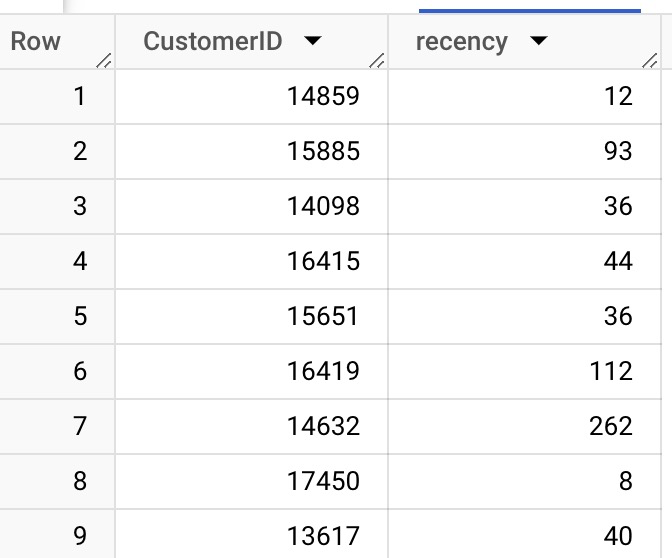

In [ ]:
# Frequency

CREATE OR REPLACE TABLE project_name.modulabs_project.user_rf AS

-- (1) 전체 거래 건수 계산
WITH purchase_cnt AS ( 
  SELECT
  CustomerID
  , COUNT(DISTINCT InvoiceNo ) AS purchase_cnt
FROM aiffel-ds-2024.quest_node15_0115.data
GROUP BY CustomerID
),

-- (2) 구매한 아이템 총 수량 계산
item_cnt AS (
  SELECT
  CustomerID,
  SUM(Quantity) AS item_cnt
FROM aiffel-ds-2024.quest_node15_0115.data
GROUP BY 1
)

-- 기존의 user_r에 (1)과 (2)를 통합
SELECT
  pc.CustomerID,
  pc.purchase_cnt,
  ic.item_cnt,
  ur.recency
FROM purchase_cnt AS pc
JOIN item_cnt AS ic
  ON pc.CustomerID = ic.CustomerID
JOIN project_name.modulabs_project.user_r AS ur
  ON pc.CustomerID = ur.CustomerID;

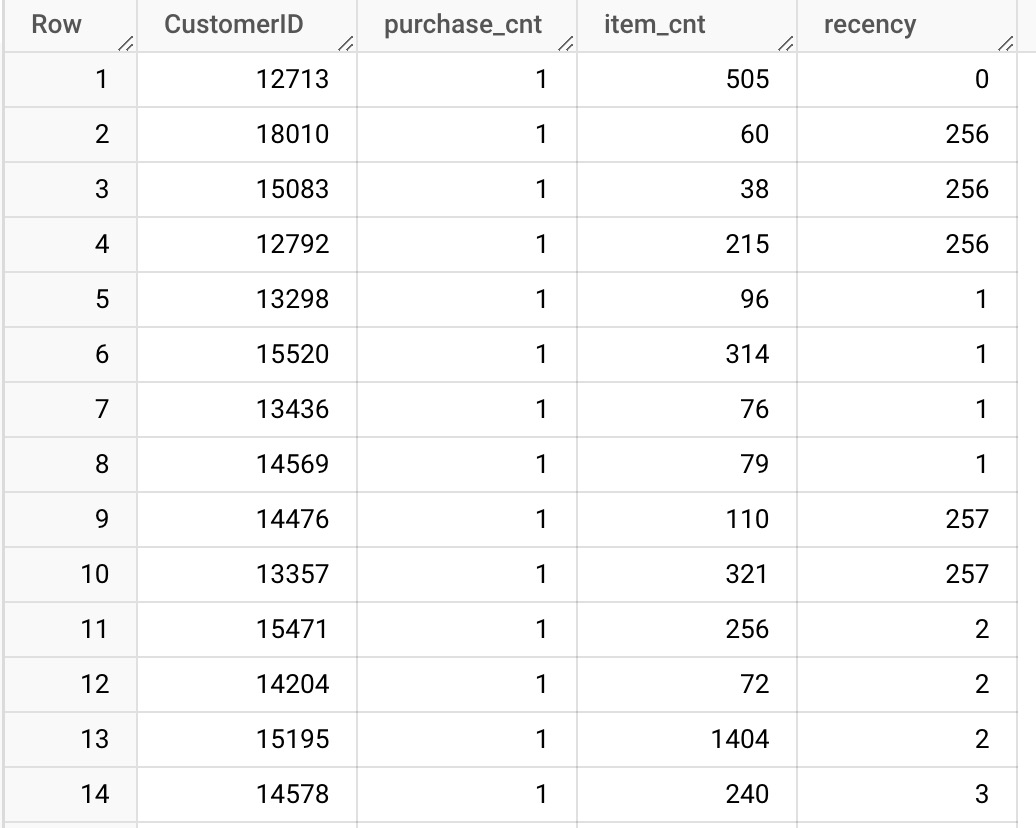

In [ ]:
# Monetary
## 고객이 지불한 총 금액

# 고객별 총 지출액을 계산해 보세요. 소수점 첫째 자리에서 반올림하세요.

SELECT
  CustomerID,
  ROUND(SUM(UnitPrice*Quantity), 1) AS user_total
FROM aiffel-ds-2024.quest_node15_0115.data
GROUP BY 1;


# 2. 고객별 평균 거래 금액 계산
CREATE OR REPLACE TABLE aiffel-ds-2024.quest_node15_0115.user_rfm AS   
SELECT
  rf.CustomerID AS CustomerID,
  rf.purchase_cnt,
  rf.item_cnt,
  rf.recency,
  ut.user_total,
  (ut.user_total / rf.purchase_cnt ) AS user_average
FROM aiffel-ds-2024.quest_node15_0115.user_rf rf
LEFT JOIN (
  -- 고객 별 총 지출액
SELECT
  CustomerID,
  ROUND(SUM(UnitPrice*Quantity), 1) AS user_total
FROM aiffel-ds-2024.quest_node15_0115.data
GROUP BY 1
) ut
ON rf.CustomerID = ut.CustomerID;

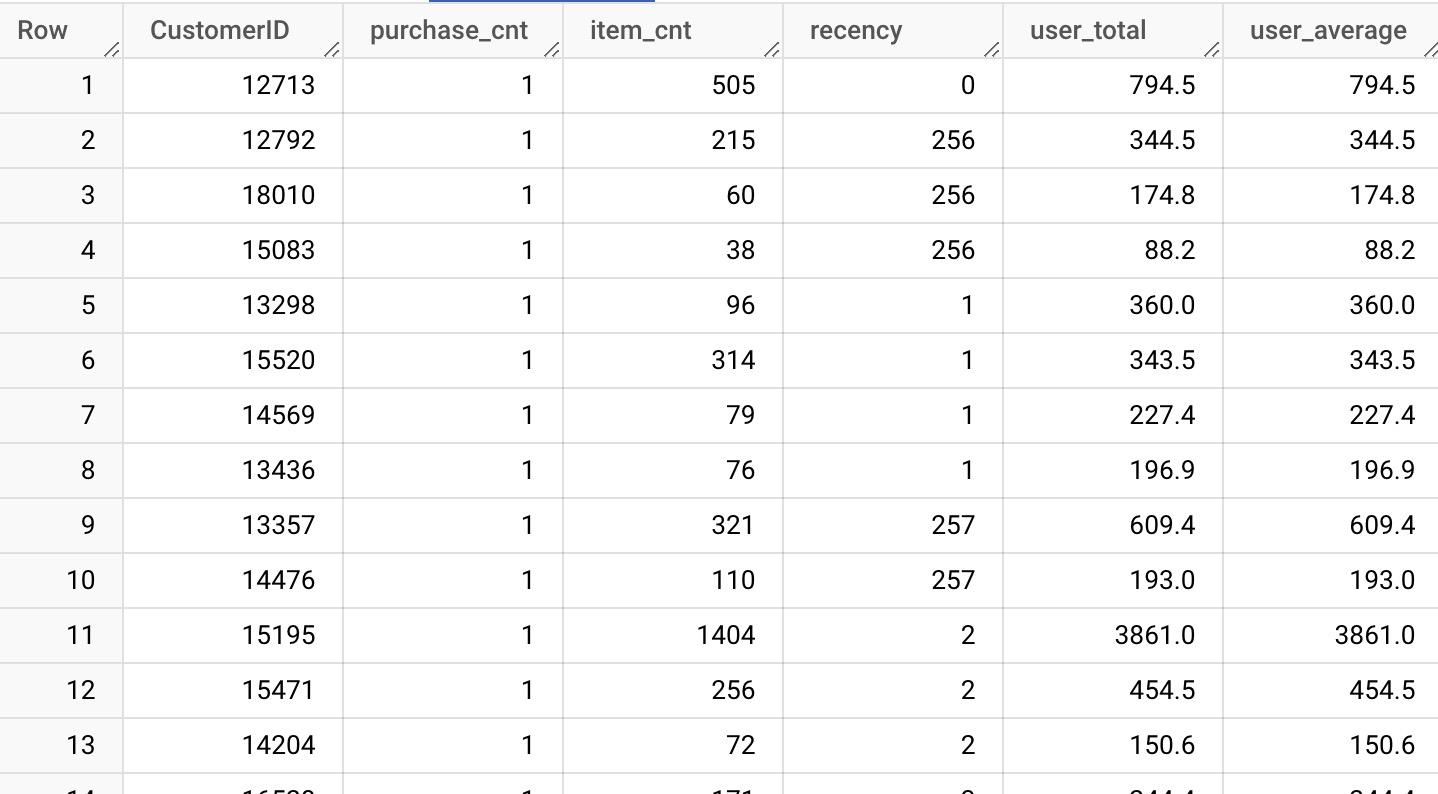

# 추가 Feature 추출
RFM 만 가지고는 RFM 은 동일하고 다른 feature 에서 차이를 보이는 고객은 세그멘테이션이 안됨

- 구매하는 제품의 다양성
    : 다양할수록 충성도가 높은 고객
- 평균 구매 주기
- 구매 취소 경향성


### Features
- 다양한 속성 정보들을 모두 다 수집한 이후에 머신러닝을 활용하여 고객들을 자동으로 분류할 수 있는, 클러스터링 알고리즘을 활용해 볼 예정
- 클러스터링 알고리즘은 비슷한 특성을 가진 데이터 포인트들을 그룹화하는 기술
    - e.g. K-Means 클러스터링, 계층적 클러스터링, DBSCAN 등
- 클러스터링을 진행하기에 앞서, 유저별 구매 특성을 더 다양하게 뽑아보도록 하겠습니다.

In [ ]:
# 1. 구매하는 제품의 다양성
## 1) 고객 별로 구매한 상품들의 고유한 수를 계산
## 2) user_rfm 테이블과 결과를 합치고, 이를 3) user_data라는 이름의 테이블에 저장


CREATE OR REPLACE TABLE aiffel-ds-2024.quest_node15_0115.user_data AS  
WITH unique_products AS (
  SELECT
    CustomerID,
    COUNT(DISTINCT StockCode) AS unique_products
  FROM aiffel-ds-2024.quest_node15_0115.data
  GROUP BY CustomerID
)
SELECT ur.*, up.* EXCEPT (CustomerID)
FROM aiffel-ds-2024.quest_node15_0115.user_rfm AS ur
JOIN unique_products AS up
ON ur.CustomerID = up.CustomerID;



In [ ]:
# 2. 평균 구매 주기
## 고객 별 재방문 주기 -> 고객들의 구매와 구매 사이의 기간이 평균적으로 몇 일인지를 보여주는 평균 일수

CREATE OR REPLACE TABLE aiffel-ds-2024.quest_node15_0115.user_data AS 

WITH purchase_intervals AS (
  -- (2) 고객 별 구매와 구매 사이의 평균 소요 일수
  SELECT
    CustomerID,
    CASE WHEN AVG(interval_) IS NULL THEN 0 ELSE ROUND(AVG(interval_), 2)
    END AS average_interval
  FROM (
    -- (1) 구매와 구매 사이에 소요된 일수
    SELECT
      CustomerID,
      DATE_DIFF( LAG(DATE(InvoiceDate), 1) OVER ( PARTITION BY CustomerID ORDER BY InvoiceDate DESC )

         , DATE(InvoiceDate), DAY) AS interval_
    FROM
      aiffel-ds-2024.quest_node15_0115.data
    WHERE CustomerID IS NOT NULL
  )
  GROUP BY 1
)
SELECT pi.*, ud.* EXCEPT(CustomerID)
FROM aiffel-ds-2024.quest_node15_0115.user_data ud
  JOIN purchase_intervals pi USING (CustomerID)



#### Note

    CASE WHEN AVG(interval_) IS NULL THEN 0 ELSE ROUND(AVG(interval_), 2)
이 부분이 왜 IS NULL 을 따로 처리해주는지 몰랐는데
LAG 함수에서 이전 값이 없을 경우 null 이 되기 때문에 해당 경우를 제외하기 위해, 즉 단건 구매의 경우 interval 을 0으로 하기 위해 이렇게 해준 것 같다
다만, 왜 null 로 두지 않고 0 으로 하는지 이해가 안갔다. avg_interval 이 작을수록 이용 빈도가 높은 사람이라는 뜻일 텐데, 그렇다면 0이 최소값이니 차라리 null 처리하는게 낫지 않나?

-> GPT 에게 물어보니 0 으로 할지 null 로 할지는 그냥 내가 정하면 되는 것 같다.

> Using 0:
Implies a deliberate choice to treat single-transaction customers as having the lowest possible average_interval.
Can be useful if you want to include these customers in calculations or comparisons where an actual numerical value is needed.
Makes it clear that the customer has made a purchase, but there is no interval to measure.
> Using NULL:
Represents the absence of data or that it's not applicable, which is technically accurate for single-transaction customers.
In some analyses, NULL can be more meaningful, as it clearly indicates that there's no interval to average.
Can be excluded from certain types of calculations or require special handling in SQL functions that do not process NULL values the same way as numeric values.

In [ ]:
# 3. 구매 취소 경향성
## 1. 취소 빈도(cancel_frequency) - 취소 빈도는 고객 별로 취소한 거래의 총 횟수입니다.

## 2. 취소 비율(cancel_rate) - 취소 비율은 각 고객이 한 모든 거래 중에서 취소를 한 거래의 비율

CREATE OR REPLACE TABLE aiffel-ds-2024.quest_node15_0115.user_data AS

WITH TransactionInfo AS (
  SELECT
    CustomerID,
    COUNT(DISTINCT InvoiceNo) AS total_transactions,
    COUNT(DISTINCT CASE WHEN InvoiceNo LIKE 'C%' THEN InvoiceNo ELSE NULL END) AS cancel_frequency
  FROM aiffel-ds-2024.quest_node15_0115.data
  GROUP BY 1
)

SELECT u.*, t.* EXCEPT(CustomerID), 
( t.cancel_frequency / t.total_transactions) AS cancel_rate
FROM aiffel-ds-2024.quest_node15_0115.user_data AS u
LEFT JOIN TransactionInfo AS t
USING (CustomerID)


### Note

    COUNT(DISTINCT InvoiceNo WHERE InvoiceNo LIKE 'C%' ) AS cancel_frequency

Count 안에 WHERE 를 쓸 순 없어서 CASE WHEN 으로 바꿔줘야 한단다. 대신 ELSE NULL 로 해서 총계를 구한다

    COUNT(CASE WHEN InvoiceNo LIKE 'C%' THEN DISTINCT InvoiceNo ELSE NULL ) AS cancel_frequency
    


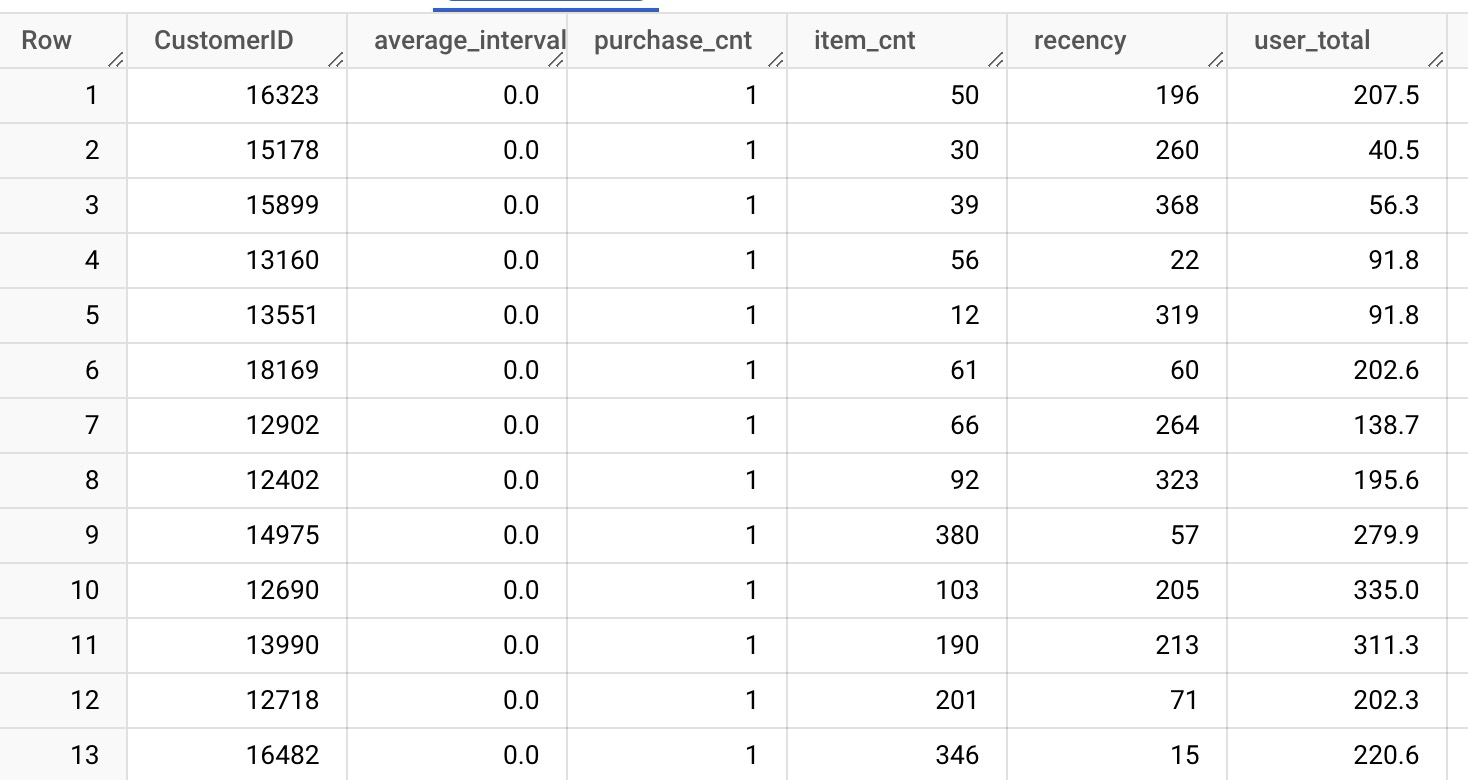

## user.data 테이블 csv 추출 후 파이썬으로 읽어들이기

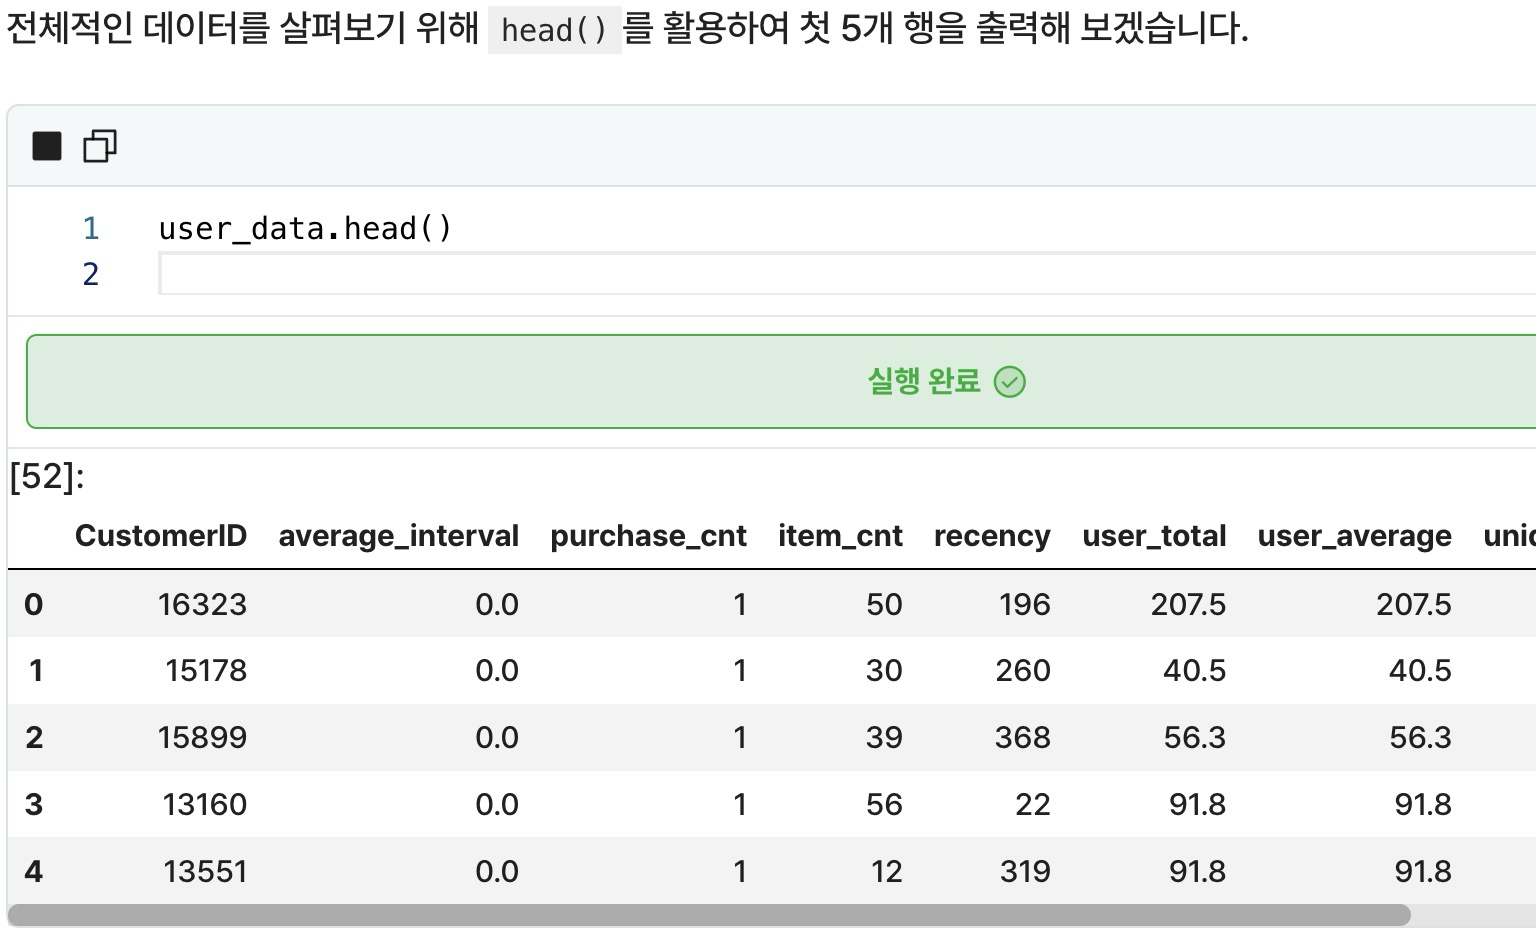

-----

# 회고
- 지금까지가 '재료 손질' 과 '데치기' 정도 과정이었던 것 같은데, 하루 종일 걸렸다!
- 익숙해지면 반나절이면 될까?
- Problem Finding 과 Problem Solving 을 같이 한다. 탐정이 된 것 같아서 재미있다
- 시각화 전단계여서 사실 (루브릭 용) 어떻게 인사이트를 도출할 수 있는건지 잘 모르겠다
- 통계가 왜 중요해질지(?) 조금 힌트를 얻었다. UnitPrice 편차가 커보였고 다른 컬럼들도 그냥 avg 로 나타내기에는 대표성이 없어보였는데..?
- Segmentation 에서 나누는 기준 선을 어떻게 잡게 될지 궁금하다